In [139]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os

### Читаем dtaframe

In [165]:
df = pd.read_csv('~/kaggle/input/moscow_metro_stations.csv')
df.head()

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Latitude,Longitude,Station_Type
0,1,Bulvar Rokossovskogo,1,Бульвар Рокоссовского,-8.0,2,266,1990-08-01,55.8147,37.7342,column triple-span
1,2,Cherkizovskaya,1,Черкизовская,-9.0,1 3,267,1990-08-01,55.8039,37.7447,single-vault shallow
2,3,Preobrazhenskaya Ploshchad,1,Преображенская площадь,-8.0,2 4,NaN,1965-12-31,55.7964,37.7150,column triple-span
3,4,Sokolniki,1,Сокольники,-9.0,3 5,221,1935-05-15,55.7889,37.6803,single-vault shallow
4,5,Krasnoselskaya,1,Красносельская,-8.0,4 6,NaN,1935-05-15,55.7799,37.6673,column double-span


In [141]:
My_Line_Colors = {
    1:'#EF161E',
    2:'#2DBE2C',
    3:'#0078BE',
    4:'#00BFFF',
    5:'#8D5B2D',
    6:'#ED9121',
    7:'#800080',
    8:'#FFD702',
    9:'#999999',
    10:'#99CC00',
    11:'#82C0C0',
    12:'#A1B3D4',
    13:'#00008B',
    14:'#FFC0CB',
    15:'#DE64A1',
    16:'#03795F',
    17:'#27303F',
    18:'#AC1753'
}

# How this colors looks like

colors = []
for i in range(1, 19):
    if i == 13:
        continue
    colors.append(My_Line_Colors[i])

### Строим граф

In [142]:
my_stations = []
edges = []

for index, row in df.iterrows():
    
    new_line = (row['Station_index'], row['English_name'], row['Line'], (row['Longitude'], row['Latitude']))
    my_stations.append(new_line)
    for i in str(row['Line_Neighbors']).split():
        edges.append((row['Station_index'], int(i)))

In [150]:
transfers = []
for index, row in df.iterrows():
    for i in str(row['Transfers']).split():
        if i == 'nan':
            continue
        transfers.append((row['Station_index'], int(i)))
        
stations = my_stations

# Create graph
G = nx.Graph()

# Add stations and lines
G.add_nodes_from([(s[0], {'name': s[1], 'line': s[2], 'pos': s[3]}) for s in stations])

# Add edges + transfers
G.add_edges_from(edges + transfers)

## Часть 1: запустить Pagerank

In [152]:
# Pagerank
pr = nx.pagerank(G)

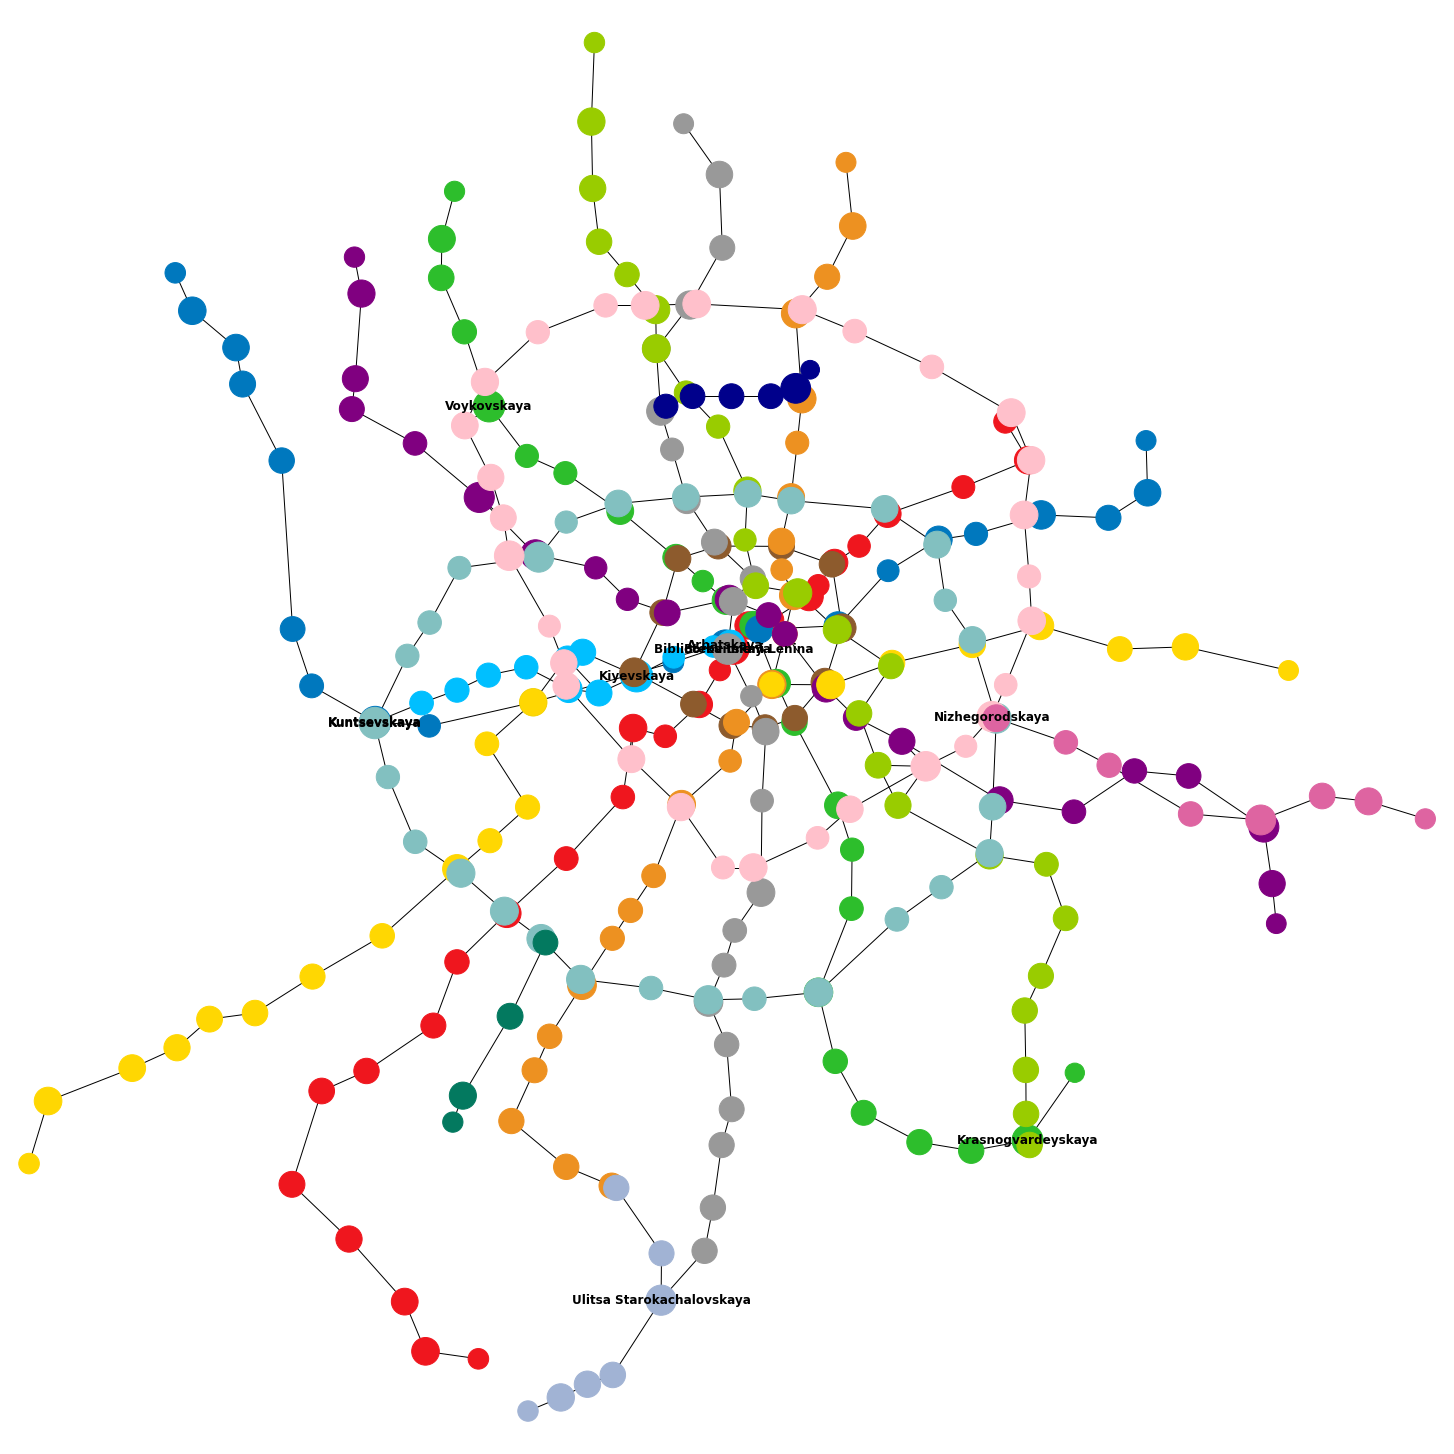

In [147]:
# Visualize
pos = {node[0]: node[1]['pos'] for node in G.nodes(data=True)}
node_colors = [node[1]['line'] for node in G.nodes(data=True)]
edge_colors = [G[u][v].get('color', 'black') for u, v in G.edges()]

# Map line colors to numerical values
line_colors = My_Line_Colors
node_colors = [line_colors[color] for color in node_colors]

# Get top and create lables
n = 10
top = sorted(list(map(lambda k: (k, stations[k-1][1], pr[k]), pr)), key=lambda x: x[2], reverse=True)[0:n]
labels = dict(list(map(lambda t: (t[0], t[1]), top)))

plt.figure(figsize=(20, 20))
nx.draw(G, pos, with_labels=True, node_size=200000 * np.array(list(pr.values())), 
                labels=labels,
                node_color=node_colors, edge_color=edge_colors, font_weight='bold')
plt.xlim(df.Longitude.min() - 0.01, df.Longitude.max() + 0.01)
plt.ylim(df.Latitude.min() - 0.01, df.Latitude.max() + 0.01)
plt.show()

In [153]:
print(*top, sep="\n")

(83, 'Kiyevskaya', 0.005179916258299966)
(32, 'Voykovskaya', 0.0049401351351643875)
(240, 'Kuntsevskaya', 0.004910503788157169)
(59, 'Kuntsevskaya', 0.004892204606901952)
(50, 'Krasnogvardeyskaya', 0.004824981792204116)
(179, 'Borovitskaya', 0.004680443130104866)
(11, 'Biblioteka Imeni Lenina', 0.004646997746980592)
(64, 'Arbatskaya', 0.004604792827126405)
(272, 'Nizhegorodskaya', 0.00458858324433564)
(250, 'Ulitsa Starokachalovskaya', 0.004553603135102041)


## Часть 2: написать и сравнить simrank

In [245]:
values = nx.simrank_similarity(G)

In [246]:
S = np.array([list(values[i].values()) for i in range(1, len(values) + 1)])

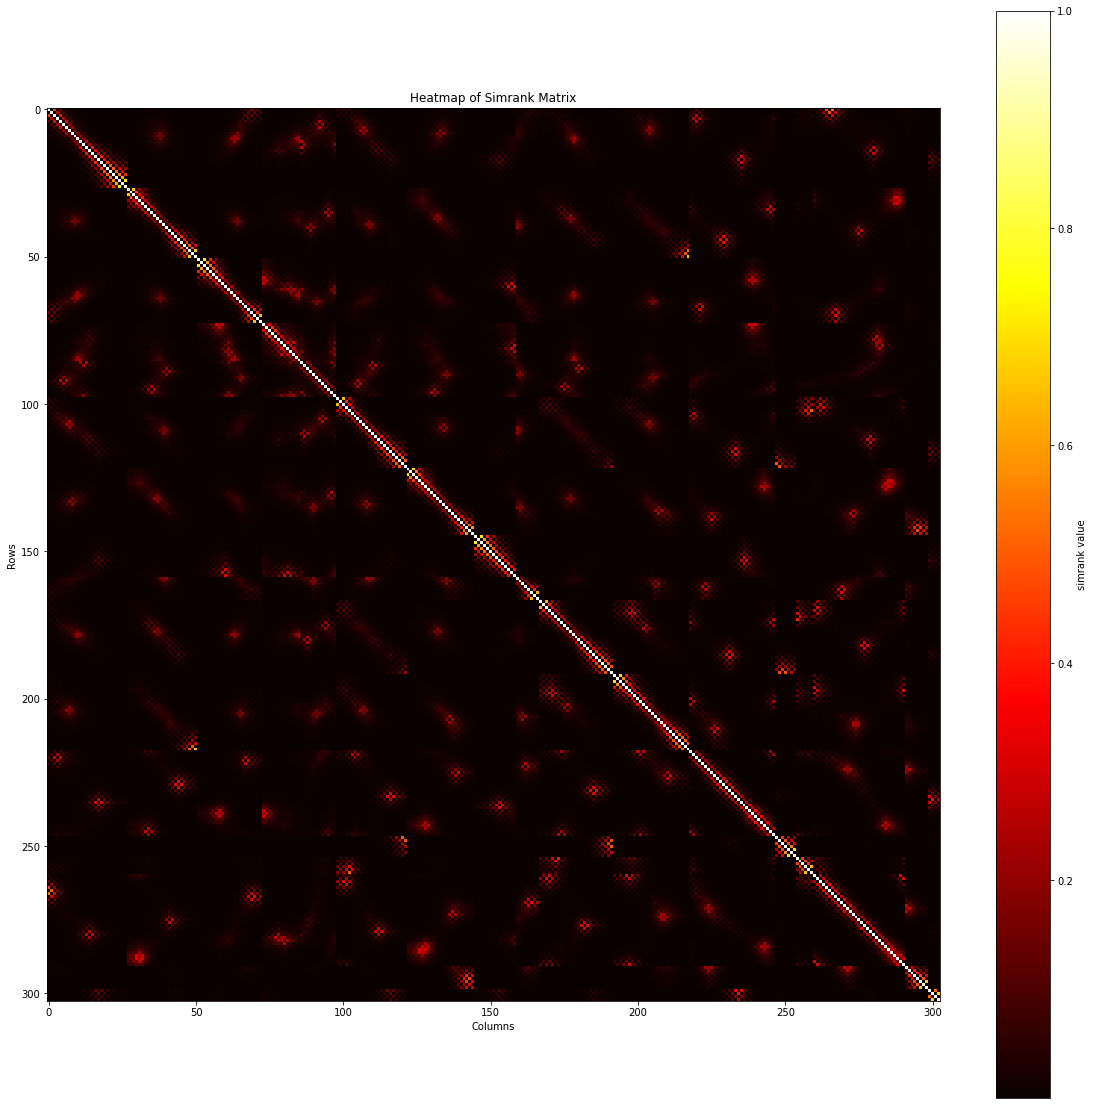

In [247]:
plt.figure(figsize=(20, 20))
plt.imshow(S, cmap='hot', interpolation='none')
plt.colorbar(label='simrank value')
plt.title('Heatmap of Simrank Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [248]:
# get adjacency matrix
A_tilde = nx.adjacency_matrix(G).toarray()
A_hat = np.zeros(A_tilde.shape)

for i in range(A_tilde.shape[1]):
    A_hat[:, i] = A_tilde[:, i] / np.sum(A_tilde[:, i])

def f(S, A = A_hat):
    c = 0.9
    production = A.T @ S @ A
    return c * production  + np.eye(S.shape[0]) - c * np.diag(np.diag(production))

def simple_iteration(f, tol=1e-4):
    global A_hat
    S = np.eye(A_hat.shape[0])
    error = 1
    while error > tol:
        S_new = f(S)
        error = np.linalg.norm(S_new - S)
        S = S_new
    return S

In [249]:
my_S = simple_iteration(f)

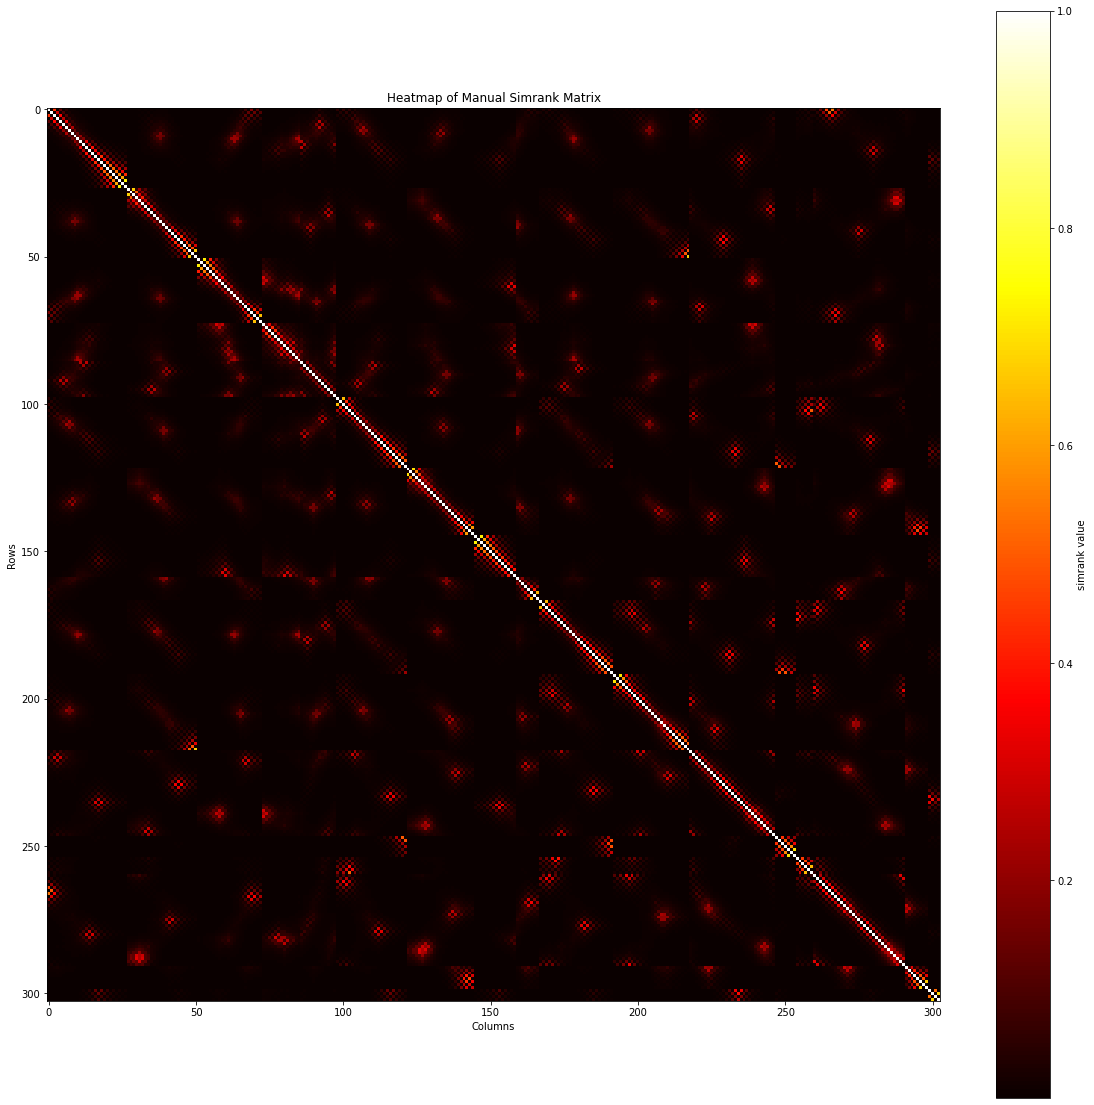

In [250]:
plt.figure(figsize=(20, 20))
plt.imshow(my_S, cmap='hot', interpolation='none')
plt.colorbar(label='simrank value')
plt.title('Heatmap of Manual Simrank Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

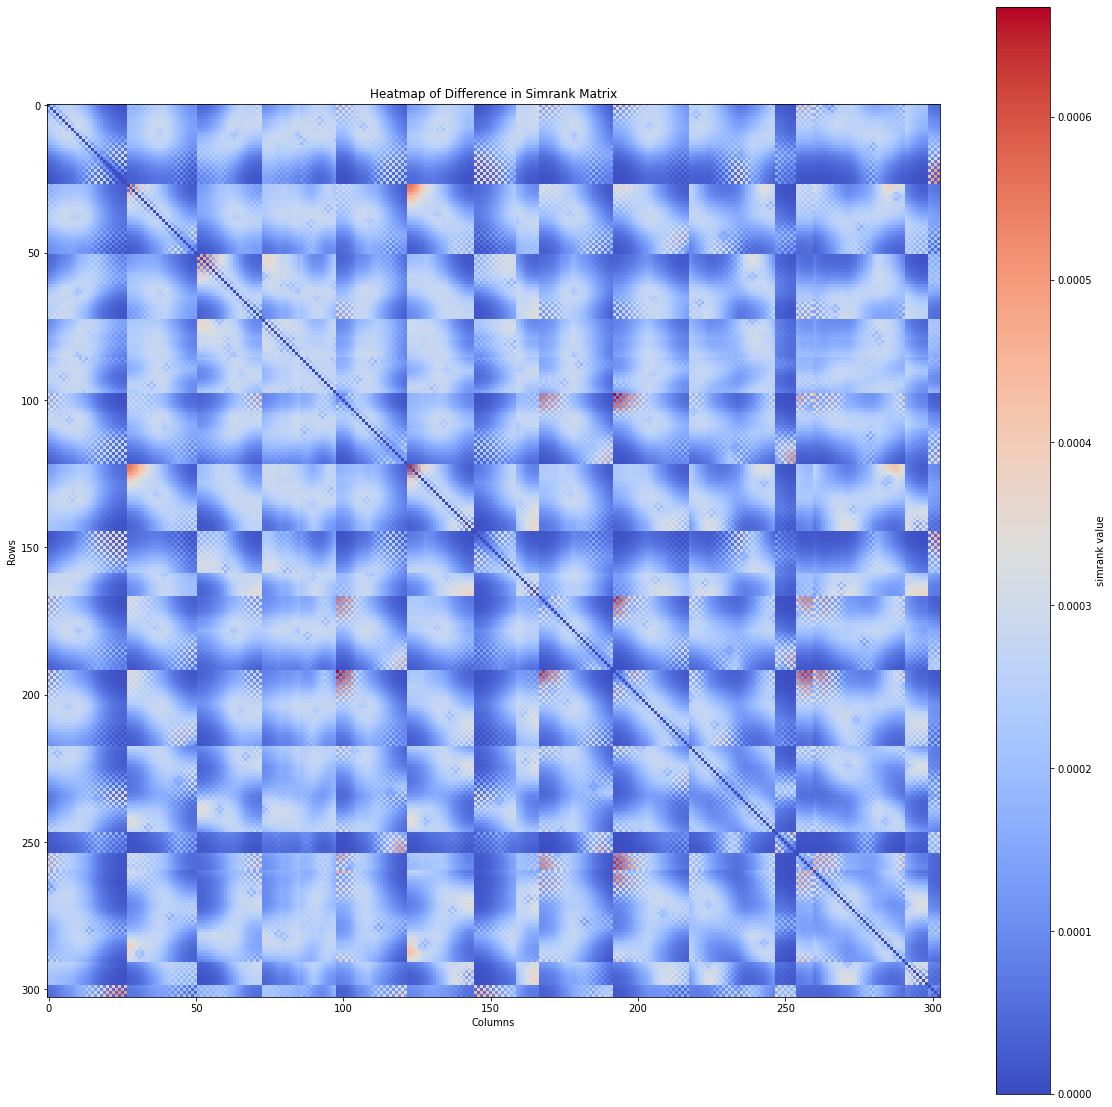

In [251]:
plt.figure(figsize=(20, 20))
plt.imshow(my_S - S, cmap='coolwarm', interpolation='none')
plt.colorbar(label='simrank value')
plt.title('Heatmap of Difference in Simrank Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()